## Making sure Metropolis-Hastings works

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

In [90]:
def energy(sequence, J):
    """
    Calculate the Hamiltonian of the sequence.
    Args:
        sequence (np.array): The current sequence of spins.
        J (np.array): Interaction matrix.
    Returns:
        float: The energy of the current sequence.
    """
    return -np.sum(J * np.outer(sequence, sequence))

def set_interaction_mat(size, prob=[0.5,0.5]):
    J = np.random.choice([0,1],(size,size),p=prob) # interaction matrix
    J = J.T + J
    J[J==2] = 1
    J[J==-2] = -1
    return J

In [91]:
def propose_sequence(current_sequence, num_of_flips=1, prob=0.5):
    """
    Propose a new sequence by flipping a set number of spins.
    Args:
        current_sequence (np.array): The current sequence of spins.
        num_of_flips (int): Number of spins to flip.
    Returns:
        np.array: The proposed sequence of spins.
    """
    new_sequence = current_sequence.copy()
    flip_indices = np.random.choice(len(new_sequence), num_of_flips, replace=False)
    #flip_indices = np.random.uniform(0, 1, size=num_of_flips) < prob
    #new_sequence[flip_indices] = -new_sequence[flip_indices]
    new_sequence[flip_indices] *= -1
    return new_sequence

def identify_and_flip_clusters(current_sequence, J, T):
    """
    Identify clusters based on J and propose a new sequence by flipping one of these clusters.
    Args:
        current_sequence (np.array): The current sequence of spins.
        J (np.array): Interaction matrix providing lattice and neighborhood information.
        T (float): Temperature, influencing the probability of flipping a cluster.
    Returns:
        np.array: The proposed sequence of spins after possibly flipping a cluster.
    """
    new_sequence = current_sequence.copy()
    size = len(current_sequence)
    # Randomly choose a starting point for the cluster
    start_index = np.random.randint(size)
    cluster = [start_index]
    for i in cluster:
        for j in range(size):
            # If spins are interacting strongly and not yet in the cluster, add them
            if J[i, j] > 0 and j not in cluster and current_sequence[i] == current_sequence[j]:
                # Add to the cluster based on a probability related to the interaction strength and temperature
                if np.random.rand() < np.exp(J[i, j] / T):
                    cluster.append(j)
    
    # Flip the entire cluster with some probability (could be based on size, energy, etc.)
    if np.random.rand() < 0.5:  # Example probability, adjust as needed
        for i in cluster:
            new_sequence[i] = -new_sequence[i]
    
    return new_sequence

def metropolis_hastings(J, initial_sequences, num_iters, T=1.0, num_of_flips=1):
    """
    Perform the Metropolis-Hastings algorithm on multiple sequences.
    Args:
        J (np.array): Interaction matrix.
        initial_sequences (list of np.array): Initial sequences of spins.
        num_iterations (int): Number of iterations to perform.
        T (float): Temperature.
        num_of_flips (int): Number of spins to flip in each proposal.
    Returns:
        list of np.array: Final sequences after iterations.
    """
    current_sequences = initial_sequences.copy()
    log_sequences = np.zeros((len(current_sequences), num_iters))
    updated_log_sequences = []
    accepted_states = np.zeros(len(current_sequences))
    for n in range(num_iters):
        for i in range(len(current_sequences)):
            num_of_flips = np.random.randint(1,20)
            proposed_sequence = propose_sequence(current_sequences[i], num_of_flips)
            current_energy = energy(current_sequences[i], J)
            proposed_energy = energy(proposed_sequence, J)
            energy_difference = proposed_energy - current_energy
            if (energy_difference < 0):
                current_sequences[i] = proposed_sequence
                accepted_states[i]+=1

            else:
                if np.random.uniform(0,1)<np.exp(-energy_difference/T):
                    current_sequences[i] = proposed_sequence
                    #log_sequences[:,accepted_states[i]] = np.absolute(np.sum(np.array(current_sequences), axis=1))
                    accepted_states[i]+=1
        log_sequences[:,n] = np.absolute(np.sum(np.array(current_sequences), axis=1)/len(current_sequences[0]))

    #for i in range(len(current_sequences)):
    #    updated_log_sequences.append(np.unique(log_sequences[i,:]))
    return current_sequences, log_sequences, accepted_states

# Example usage:
np.random.seed(42)  # For reproducibility

size = 200  # Size of each sequence
num_sequences = 400  # Number of sequences
J = set_interaction_mat(size) # Example interaction matrix, should be symmetric
initial_sequences = [np.random.choice([-1, 1], size=size) for _ in range(num_sequences)]

final_sequences, log_sequences, accepted_states = metropolis_hastings(J, initial_sequences, num_iters=1000, T=5.0, num_of_flips=10)
# Final_sequences contains the sequences after they have potentially reached their stable states


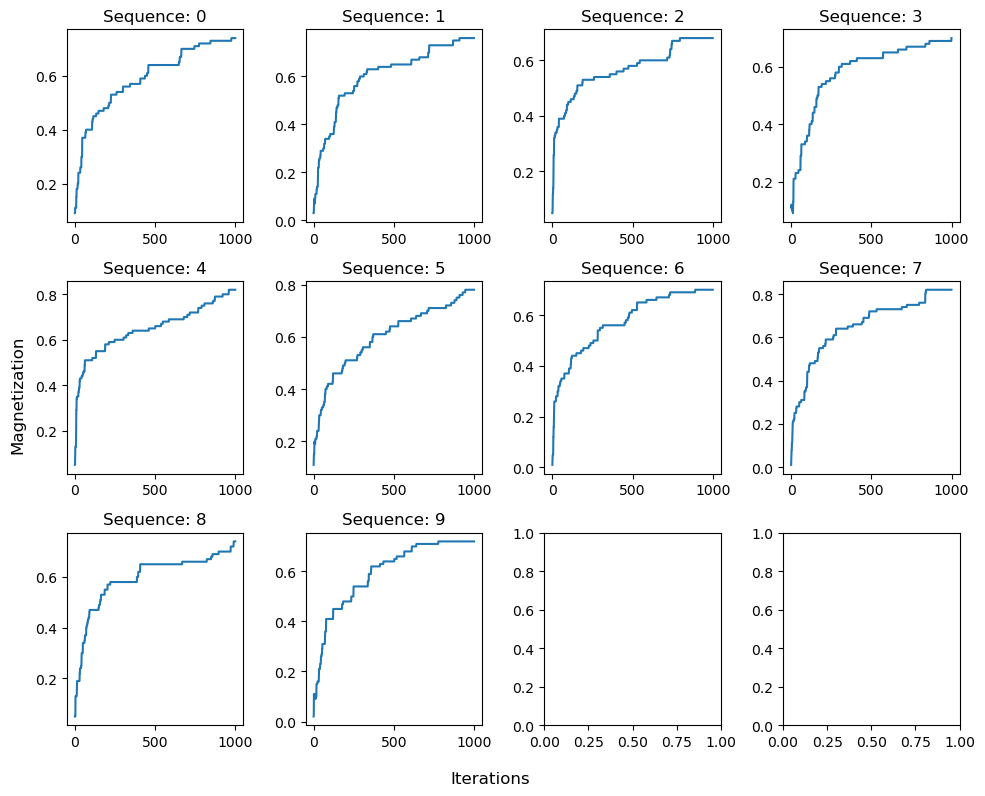

In [92]:
def plotting_magnetization(log_sequences, num_iters):
    fig, ax = plt.subplots(3, 4, figsize=(10,8))
    k = 0
    for i in range(3):
        for j in range(4):
            ax[i,j].plot(np.arange(num_iters), log_sequences[k])
            ax[i,j].set_title("Sequence: "+str(k))
            k +=1
            if k == 10:
                break
    fig.supxlabel("Iterations")
    fig.supylabel("Magnetization")
    plt.tight_layout()
    plt.show()
plotting_magnetization(log_sequences, 1000)
#print(accepted_states)
#print(log_sequences)


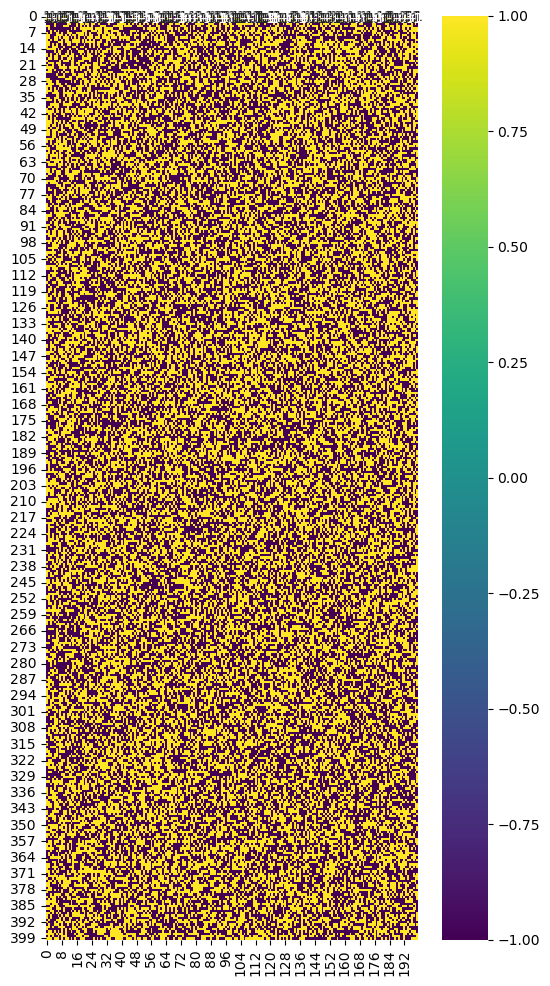

In [93]:
plt.figure(figsize=(6,12))
sns.heatmap(np.array(initial_sequences), cmap='viridis', annot=True)
plt.show()

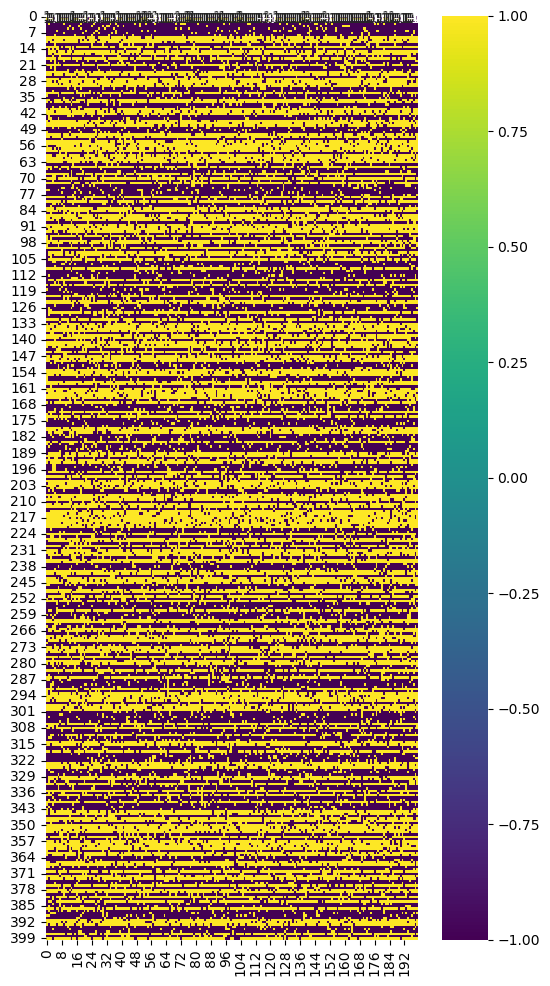

In [94]:
plt.figure(figsize=(6,12))
sns.heatmap(np.array(final_sequences), cmap='viridis', annot=True)
plt.show()

In [25]:
final_chains = np.array(final_sequences)
initial_chains = np.array(initial_sequences)
print("Number of chains:",final_chains.shape[0])
print("Number of spins in the chain:",final_chains.shape[1])

Number of chains: 400
Number of spins in the chain: 200


## Calculating TP fraction
1. Calculate covariance (or correlation matrix) (imported from the authors implementation)
2. Calculate frequencies

In [26]:
def ComputeCorrelationMatrix2(mat, pseudocount):
    
    nbr_spins = len(mat[0,:])
    nbr_chains = len(mat[:,0])
    mat = np.array(mat,ndmin = 2, dtype = np.float64)
    average_spin = np.average(mat, axis = 0)[:,None]
    
    directcorr = np.dot(mat.T, mat)
    
    directcorr *= np.true_divide(1, nbr_chains, dtype = np.float64)
    
    correlation_matrix = np.dot(1.0-pseudocount, directcorr) - np.dot(pow(1-pseudocount,2),np.outer(average_spin.T, average_spin)) + np.dot(pseudocount,np.identity(nbr_spins))
    
    return correlation_matrix

corr_mat = ComputeCorrelationMatrix2(final_chains, 0.5)
#corr_mat

In [39]:
mat = np.array(initial_sequences)
print(type(initial_sequences))
one_to_one = np.sum(mat[(mat[:,1]==mat[:,3])&(mat[:,1]==1)])
print(one_to_one)

<class 'list'>
100


In [71]:
def calc_frequency(mat,pseudocount):
    f = np.zeros((mat.shape[1]))
    for i in range(len(f)):
        f[i] = (1-pseudocount)*np.sum(mat[:,i] == 1)/mat.shape[0] + pseudocount/mat.shape[1]
    return f

def coupled_frequency(mat,pseudocount):
    n_seq,nbrpos = mat.shape
    nbrstates = np.unique(mat).shape[0]
    frequencies = calc_frequency(mat,pseudocount)
    binst = np.linspace(0,nbrstates, nbrstates+1)
    jointfreq = np.zeros((nbrpos,nbrpos,4))
    for i in range(0,nbrpos):    
        for j in range(0,nbrpos):
            if i != j:
                #fri = pseudocount/(nbrstates) + (1-pseudocount)*frequencies[:,i]
                #frj = pseudocount/(nbrstates) + (1-pseudocount)*frequencies[:,j]
                #hist2d,_,_ = np.histogram2d(mat[:,i],mat[:,j],bins = binst) -> doesn't output correct result
                # 1 and 1
                a, b = mat[:,i], mat[:,j]
                one_to_one = np.sum(mat[:,i][(a==b)&(a==1)])
                mone_to_mone = np.abs(np.sum(mat[:,i][(a==b)&(a==-1)]))
                mone_to_one = np.abs(np.sum(mat[:,i][(a!=b)&(a==-1)]))
                one_to_mone = np.sum(mat[:,i][(a!=b)&(a==1)])
                pair_hist = np.array([one_to_one, one_to_mone, mone_to_one, mone_to_mone])
                jointfreq[i,j,:] = (pseudocount/(nbrstates)**2) + (1-pseudocount)*pair_hist/n_seq
    return jointfreq
#print("Individual frequency for occurence of 1:",calc_frequency(final_chains, 0.5))
#print("Coupled frequency:",coupled_frequency(initial_chains, 0.5))
joint_freq = coupled_frequency(initial_chains, 0.5).reshape((200,200,2,2))
print(joint_freq.shape)


(200, 200, 2, 2)


In [72]:
def MI(f_coupled, f_ind, mat):
    MI_calc = np.zeros((mat.shape[1], mat.shape[1]))
    for i in range(mat.shape[1]):
        for j in range(i+1, mat.shape[1]):
            #print("Coupled frequency: ",f_coupled[i,j])
            #print("Individual frequency i: ",f_ind[i])
            #print("Individual frequency j: ",f_ind[j])
            MI_calc[i,j] = -entropy(f_coupled[i,j,:]) + entropy(f_ind[i]) + entropy(f_ind[j]) #np.log(f_coupled[i,j]/(f_ind[i]*f_ind[j]))
            #MI_calc[i,j] = entropy(pk=f_coupled[i,j,:], qk=f_ind[i]*f_ind[j])
            #MI_calc[i,j] = f_coupled[i,j]*np.log(f_coupled[i,j]/(f_ind[i]*f_ind[j]))
    return MI_calc

MI_mat = MI(coupled_frequency(initial_chains, 0.5), calc_frequency(final_chains, 0.5), initial_chains)
print(MI_mat)

#J_estimated_C = np.linalg.inv(corr_mat)
#print(np.abs(J_estimated_C))

#plt.figure()
#sns.heatmap(np.array(J), cmap='viridis', annot=True)
#plt.show()

#plt.figure()
#sns.heatmap(np.array(corr_mat), vmax = 0.3, cmap='viridis', annot=True)
#plt.show()

[[ 0.         -1.38594108 -1.38611309 ... -1.38510293 -1.38528869
  -1.38602622]
 [ 0.          0.         -1.38579716 ... -1.38578132 -1.385888
  -1.38602491]
 [ 0.          0.          0.         ... -1.38596136 -1.38599972
  -1.38607698]
 ...
 [ 0.          0.          0.         ...  0.         -1.3853222
  -1.38584625]
 [ 0.          0.          0.         ...  0.          0.
  -1.38541104]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [ ]:
corr_mat_copy = corr_mat.copy()
corr_mat[np.round(corr_mat,2)==1] = 0
corr_mat_copy[corr_mat<np.mean(corr_mat)] = 0
corr_mat_copy[corr_mat>np.mean(corr_mat)] = 1

#plt.figure()
#sns.heatmap(np.array(corr_mat_copy), cmap='viridis', annot=True)
#plt.show()

## Questions:
1. Do we have to consider different types of frequencies (e.g. of -1 and 1 being together or 1 and 1 being separate from -1 and -1)? **Yes, needs to be corrected**
2. Why is it necessary to use histograms of MSA? Can we just use the values for frequencies? **Any distribution or function will do**
3. How do you infer J from MI? **Take the inverse and normalise or normlaise and take the inverse**
4. Plot in terms of accepted steps


> mfDCA - on simulated data

> PlmDCA - on real data (on simulated data it is overkill in terms of computing power)


## Actions:
1. Change frequency function to the correct one (+)
2. Plot the magnetization per accepted steps (-)
3. Mutual Information implementation (+)
4. Implement or import the mfDCA function (+) -> needs checking
5. Implement or import the mfDCA function (+)
6. Adapt it for different sampling temperature (-)


### Mean-field dircet coupling analysis (mfDCA)

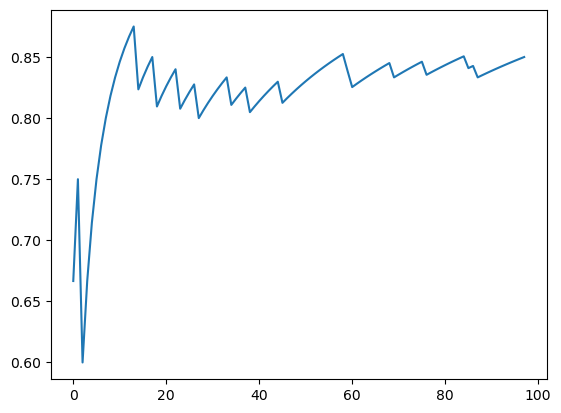

In [78]:
# imported from the supplementary code
def Inference_MF(mat_corr, matrix_contacts,bl_abs,bl_apc):
    """
    Infer the contacts using MF approximation
    """
    val,cts = np.unique(matrix_contacts,return_counts = True)
    nbrcontacts = cts[val == 1]
    flag = True
    # inverse of the correlation matrix to get the couplings
    
    try:
        inferred_couplings = np.linalg.inv(mat_corr)
    except:
        flag = False
        
    if flag:
        if bl_abs:
            inferred_couplings = np.abs(inferred_couplings)
            
        if bl_apc:
            np.fill_diagonal(inferred_couplings,0)
            S = inferred_couplings.copy()
            inferred_couplings -= (np.mean(S, axis=1, keepdims=True) * np.mean(S, axis=0, keepdims=True)) / np.mean(S)
    
        TP = []
    
        # order the 2d array and find the index of the sorted values in the matrix
        if bl_abs:
            index_sorted_array_x, index_sorted_array_y  = np.unravel_index(np.argsort(-inferred_couplings, axis=None), inferred_couplings.shape)
        else:
            index_sorted_array_x, index_sorted_array_y  = np.unravel_index(np.argsort(inferred_couplings, axis=None), inferred_couplings.shape)
    
    
        idx_flip = list(index_sorted_array_x)
        idy_flip = list(index_sorted_array_y)
    
        # indirect_corr_second_order =[]
    
        FP = []
    
        TP_coords = []
        all_coords = []
        N = 0 
        number_pairs = []
    
        list_tp = []
        TP = 0
    
        list_tp_fraction_allpairs = []
    
    
        for x, y in zip(idx_flip, idy_flip):
    
            # just look at the elements above the diagonal as symmetric matrix
            # to not count twice each contact
            if y > x:
    
                N = N + 1
    
                number_pairs.append(N)

    
                if matrix_contacts[x,y] == 1:
                    TP = TP + 1
                    if N <= nbrcontacts:
                        TP_coords.append([x,y])
                else:
    
                    if N <= nbrcontacts:
                        FP.append([x,y])

    
                list_tp.append(TP)
    
                all_coords.append([x,y])
    
                list_tp_fraction_allpairs.append(TP/N)
    
        return list_tp_fraction_allpairs, FP
    
    else:
        mat = np.zeros(nbrcontacts)
        mat[:] = np.nan
        return mat,mat
list_tp_fraction_allpairs, FP = Inference_MF(corr_mat, J,bl_abs=True,bl_apc=False)
plt.plot(list_tp_fraction_allpairs[2:100])

### Pseudo-likelihood maximisation with direct coupling analysis (plmDCA)

In [122]:
import numpy as np
from sklearn import metrics

def compute_frobenius_norm(J, apply_apc=False):
    """Compute Frobenius norm scores from couplings, optionally apply APC correction."""
    # Zero-sum gauge transformation
    J -= np.mean(J, axis=(2, 3), keepdims=True)
    J -= np.mean(J, axis=(0, 1), keepdims=True)
    J += np.mean(J)
    
    # Frobenius norm
    scores = np.sqrt(np.sum(J**2, axis=(2, 3)))
    
    # APC correction
    if apply_apc:
        mean_row = np.mean(scores, axis=1, keepdims=True)
        mean_col = np.mean(scores, axis=0, keepdims=True)
        mean_all = np.mean(scores)
        scores -= mean_row * mean_col / mean_all
    
    return scores


def inference_plmDCA(scores, true_contacts):
    """Infer contacts from scores and calculate true positive fraction."""
    nbr_contacts = np.sum(true_contacts)
    nbr_noncontacts = np.prod(true_contacts.shape) - nbr_contacts
    
    sorted_indices = np.unravel_index(np.argsort(-scores, axis=None), scores.shape)
    sorted_true_contacts = true_contacts[sorted_indices]
    
    tp = np.cumsum(sorted_true_contacts)
    fp = np.cumsum(1 - sorted_true_contacts)
    
    tp_rate = tp / nbr_contacts
    fp_rate = fp / nbr_noncontacts
    
    auc = metrics.auc(fp_rate, tp_rate)
    tp_fraction = tp[nbr_contacts - 1] / nbr_contacts
    
    return auc, tp_fraction

def example_plmDCA(J, joint_freq):
    """Example usage of plmDCA inference."""
    # Load couplings and parameters
    #path = 'path_to_data.h5'
    #Jtensor, regparam = load_couplings_and_params(path)
    Jtensor = joint_freq
    # Assume matrix_contact is given
    matrix_contact = J
    
    # Compute scores using Frobenius norm and apply APC
    Jtensor = Jtensor[:, :, :, :]
    scores = compute_frobenius_norm(Jtensor, apply_apc=True)
    
    # Infer contacts and calculate performance metrics
    auc, tp_fraction = inference_plmDCA(scores, matrix_contact)
    
    print(f'AUC: {auc}, TP Fraction: {tp_fraction}')
    return tp_fraction

# Uncomment to run the example
example_plmDCA(J, joint_freq)


(200, 200, 2, 2, 6)
AUC: 0.5073468389932625, TP Fraction: 0.7521595570823466


### Adapting for temperature

In [164]:
def propose_sequence(current_sequence, num_of_flips=10, temp=1.0):
    """
    Propose a new sequence by flipping a set number of spins.
    Args:
        current_sequence (np.array): The current sequence of spins.
        num_of_flips (int): Number of spins to flip.
    Returns:
        np.array: The proposed sequence of spins.
    """
    new_sequence = current_sequence.copy()
    #flip_indices = np.random.choice(len(new_sequence), num_of_flips, replace=False)
    flip_decisions = np.random.uniform(0, 1, size=len(new_sequence)) < np.exp(-2/temp)
    #new_sequence[flip_indices] = -new_sequence[flip_indices]
    new_sequence[flip_decisions] *= -1
    return new_sequence

def identify_and_flip_clusters(current_sequence, J, T):
    """
    Identify clusters based on J and propose a new sequence by flipping one of these clusters.
    Args:
        current_sequence (np.array): The current sequence of spins.
        J (np.array): Interaction matrix providing lattice and neighborhood information.
        T (float): Temperature, influencing the probability of flipping a cluster.
    Returns:
        np.array: The proposed sequence of spins after possibly flipping a cluster.
    """
    new_sequence = current_sequence.copy()
    size = len(current_sequence)
    # Randomly choose a starting point for the cluster
    start_index = np.random.randint(size)
    cluster = [start_index]
    for i in cluster:
        for j in range(size):
            # If spins are interacting strongly and not yet in the cluster, add them
            if J[i, j] > 0 and j not in cluster and current_sequence[i] == current_sequence[j]:
                # Add to the cluster based on a probability related to the interaction strength and temperature
                if np.random.rand() < np.exp(J[i, j] / T):
                    cluster.append(j)
    
    # Flip the entire cluster with some probability (could be based on size, energy, etc.)
    if np.random.rand() < 0.5:  # Example probability, adjust as needed
        for i in cluster:
            new_sequence[i] = -new_sequence[i]
    
    return new_sequence

def metropolis_hastings(J, initial_sequences, num_iters, T=1.0, num_of_flips=1):
    """
    Perform the Metropolis-Hastings algorithm on multiple sequences.
    Args:
        J (np.array): Interaction matrix.
        initial_sequences (list of np.array): Initial sequences of spins.
        num_iterations (int): Number of iterations to perform.
        T (float): Temperature.
        num_of_flips (int): Number of spins to flip in each proposal.
    Returns:
        list of np.array: Final sequences after iterations.
    """
    current_sequences = initial_sequences.copy()
    log_sequences = np.zeros((len(current_sequences), num_iters))
    #updated_log_sequences = []
    accepted_states = np.zeros(len(current_sequences))
    for n in range(num_iters):
        for i in range(len(current_sequences)):
            proposed_sequence = propose_sequence(current_sequences[i], num_of_flips, T)
            current_energy = energy(current_sequences[i], J)
            proposed_energy = energy(proposed_sequence, J)
            energy_difference = proposed_energy - current_energy
            if (energy_difference < 0):
                #print("if")
                current_sequences[i] = proposed_sequence
                accepted_states[i]+=1

            else:
                #print("else")
                if np.random.uniform(0,1)<np.exp(-energy_difference/T):
                    #print("uhh temperature is nice")
                    current_sequences[i] = proposed_sequence
                    #log_sequences[:,accepted_states[i]] = np.absolute(np.sum(np.array(current_sequences), axis=1))
                    accepted_states[i]+=1
        log_sequences[:,n] = np.absolute(np.sum(np.array(current_sequences), axis=1)/len(current_sequences[0]))

    #for i in range(len(current_sequences)):
    #    updated_log_sequences.append(np.unique(log_sequences[i,:]))
    return current_sequences, log_sequences, accepted_states

# Example usage:
np.random.seed(42)  # For reproducibility

size = 200  # Size of each sequence
num_sequences = 400  # Number of sequences
J = set_interaction_mat(size) # Example interaction matrix, should be symmetric
initial_sequences = [np.random.choice([-1, 1], size=size) for _ in range(num_sequences)]

final_sequences, log_sequences, accepted_states = metropolis_hastings(J, initial_sequences, num_iters=1000, T=500.0, num_of_flips=10)
# Final_sequences contains the sequences after they have potentially reached their stable states

print(np.array(final_sequences).shape)

(400, 200)


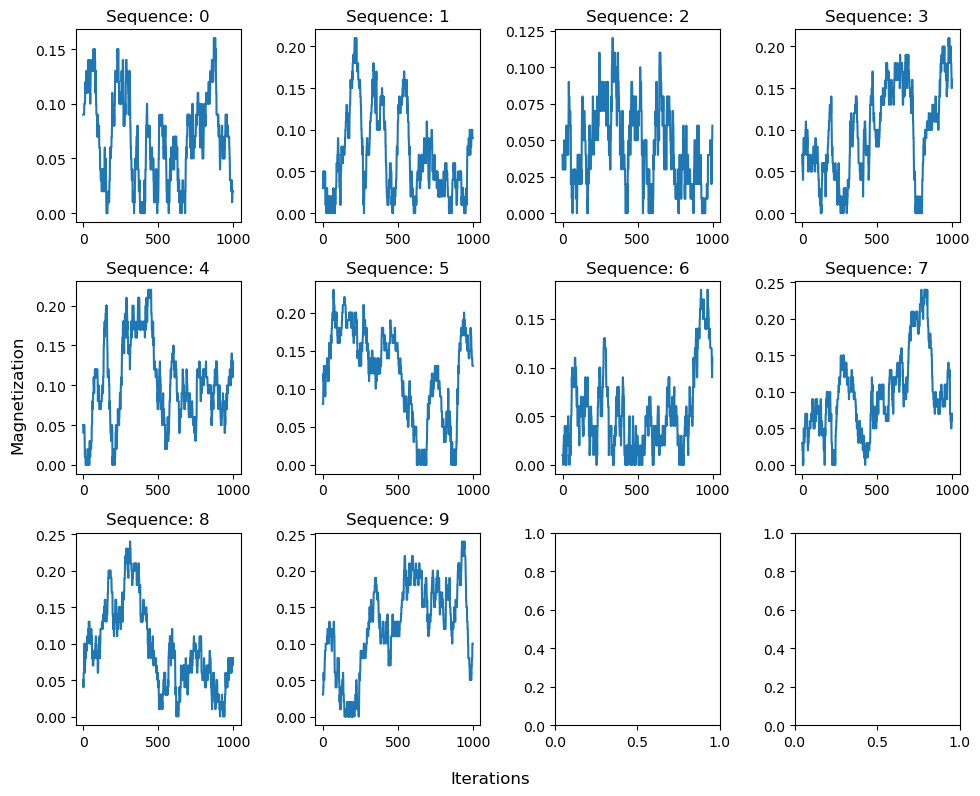

In [165]:
def plotting_magnetization(log_sequences, num_iters):
    fig, ax = plt.subplots(3, 4, figsize=(10,8))
    k = 0
    for i in range(3):
        for j in range(4):
            ax[i,j].plot(np.arange(num_iters), log_sequences[k])
            ax[i,j].set_title("Sequence: "+str(k))
            k +=1
            if k == 10:
                break
    fig.supxlabel("Iterations")
    fig.supylabel("Magnetization")
    plt.tight_layout()
    plt.show()
plotting_magnetization(log_sequences, 1000)
#print(accepted_states)
#print(log_sequences)


In [156]:
temp_list = np.arange(1,100,10)
pseudocount = 0.5
final_sequences_temp = np.zeros((num_sequences, size, len(temp_list)))
joint_freq_temp = np.zeros((size,size,2,2,len(temp_list)))
print(final_sequences_temp.shape)
for i,t in enumerate(temp_list):
    print(t)
    final_sequences_temp[:,:,i],__,__ = metropolis_hastings(J, initial_sequences, num_iters=200, T=t, num_of_flips=10)
    print(np.sum(final_sequences_temp[:10,:,i], axis=1))
    joint_freq_temp[:,:,:,:,i] = coupled_frequency(final_sequences_temp[:,:,i],pseudocount).reshape((200,200,2,2))
    print(joint_freq_temp[0,1,:,:,i])
    #Jf = joint_freq_temp[:,:,:,:,t-1].reshape((200,200,2,2))
    example_plmDCA(J, joint_freq_temp[:,:,:,:,i])


(400, 200, 10)
1
[-66.  80. -74. -62. -74. -62. -74.  78. -58.  80.]
[[0.26375 0.23375]
 [0.2375  0.265  ]]
AUC: 0.49558102225116674, TP Fraction: 0.750091718640563
11
[-68.  66. -66. -66.  78.  66. -62.  76. -72. -82.]
[[0.25625 0.24375]
 [0.21625 0.28375]]
AUC: 0.4935222568686563, TP Fraction: 0.750225127572291
21
[-76.  88.  84. -84.  74. -84. -82.  84.  96.  94.]
[[0.275   0.23375]
 [0.225   0.26625]]
AUC: 0.4979047043166397, TP Fraction: 0.7488243337891471
31
[-106.   74.   84.  -92.  -78.   94.  -88.  106.  -86.  -82.]
[[0.2775  0.22375]
 [0.23125 0.2675 ]]
AUC: 0.4852762410762259, TP Fraction: 0.7478237668011873
41
[ 94.  82. -84. 106. 104. 102.  98.  94. -88. 102.]
[[0.275   0.21125]
 [0.23    0.28375]]
AUC: 0.49527433952948036, TP Fraction: 0.750158423106427
51
[ 100. -108. -102.  100.  108. -100.  -94.   98.  102.  100.]
[[0.285   0.2    ]
 [0.21125 0.30375]]
AUC: 0.49448088468061424, TP Fraction: 0.7511589900943868
61
[ 108.  106.  -98.  116.  102.   98.  -96.   96. -110. -1

In [ ]:
plt.figure()
plt.plot()

### What to try:
- Altering the number of iterations

In [ ]:
J_copy = np.abs(J.copy())
J_copy[J_copy>=0.5] = 1
J_copy[J_copy<0.5] = 0

In [ ]:
print(np.sum(J_copy==0))

10017


In [ ]:
J_copy = J.copy()
J_copy[J_copy>=0] = 1
J_copy[J_copy<0] = 0
print(np.sum(J_copy==1))

40000


In [100]:
a = np.random.choice(10, 5, replace=False)
print(a.shape)

(5,)
